This code: merges CSV files, shows which days and hours are in the collective database, creates df, converts x, y, values in to date-time and price including VAT and energy tax 2025 (0.1228). it should prompt for energy tax values, allowing to enter future tax values.

it shows the development of price predictions for the period -4 hours till 7 x 24 hours in the future.


In [1]:
# combine all prediction files into a single database
import os
import pandas as pd
import glob
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the folder containing the CSV files
folder_path = Path("oxygent_data")

# Get all CSV files in the folder
csv_files = list(folder_path.glob("*.csv")) + list(folder_path.glob("*.CSV"))

# Sort files based on timestamp in filename
csv_files.sort(key=lambda x: x.stem.split("_")[-1].replace(":", ""))

# Read and concatenate all CSV files
df_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df_list.append(df)
        logging.info(f"Successfully read {file}")
    except Exception as e:
        logging.error(f"Error reading {file}: {e}")

if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)

    # Save the merged data
    output_file = "merged_data_price_preds.csv"
    merged_df.to_csv(output_file, index=False)
    logging.info(f"Merged {len(csv_files)} files into '{output_file}'")
else:
    logging.warning("No files were read successfully.")

2025-03-31 17:48:13,463 - INFO - Successfully read oxygent_data/time_series_data_20250328 19:45.csv
2025-03-31 17:48:13,465 - INFO - Successfully read oxygent_data/time_series_data_20250328 20:46.csv
2025-03-31 17:48:13,466 - INFO - Successfully read oxygent_data/time_series_data_20250328 21:09.csv
2025-03-31 17:48:13,468 - INFO - Successfully read oxygent_data/time_series_data_20250329 00:09.csv
2025-03-31 17:48:13,470 - INFO - Successfully read oxygent_data/time_series_data_20250329 03:09.csv
2025-03-31 17:48:13,471 - INFO - Successfully read oxygent_data/time_series_data_20250329 06:09.csv
2025-03-31 17:48:13,473 - INFO - Successfully read oxygent_data/time_series_data_20250329 10:26.csv
2025-03-31 17:48:13,493 - INFO - Successfully read oxygent_data/time_series_data_20250329 12:23.csv
2025-03-31 17:48:13,494 - INFO - Successfully read oxygent_data/time_series_data_20250329 15:24.csv
2025-03-31 17:48:13,496 - INFO - Successfully read oxygent_data/time_series_data_20250329 16:04.csv


In [2]:
# Generate descriptive statistics for the merged data
descriptive_stats = merged_df.describe()

# Print the descriptive statistics
print(descriptive_stats)
print(merged_df)

                  x              y       subarray      17431164     0.08521  \
count  7.227360e+05  722736.000000  722736.000000  9.930000e+02  993.000000   
mean   1.741948e+07       0.100640       2.855794  1.743443e+07    0.108373   
std    8.023519e+03       0.062398       1.521739  1.993810e+03    0.061130   
min    1.740352e+07      -0.213000       0.000000  1.743116e+07   -0.102000   
25%    1.741309e+07       0.065000       2.000000  1.743264e+07    0.073000   
50%    1.741932e+07       0.105000       3.000000  1.743437e+07    0.113000   
75%    1.742533e+07       0.140000       4.000000  1.743617e+07    0.152000   
max    1.744038e+07       0.365000       5.000000  1.743793e+07    0.254000   

                0  
count  993.000000  
mean     2.854985  
std      1.523048  
min      0.000000  
25%      2.000000  
50%      3.000000  
75%      4.000000  
max      5.000000  
                 x        y                         timestamp  subarray  \
0       17431164.0  0.08521  2025

In [3]:
# prepare for pivot table to visualize extend of database

# Extract dates from the 'timestamp' column
merged_df['date_timestamp'] = pd.to_datetime(merged_df['timestamp']).dt.date
# Extract hour from the 'timestamp' column
merged_df['hour_timestamp'] = pd.to_datetime(merged_df['timestamp']).dt.hour

# Create a pivot table to show unique combinations of hour_timestamp and date_timestamp
pivot_table = merged_df.pivot_table(index='hour_timestamp', columns='date_timestamp', values='timestamp', aggfunc='nunique', fill_value=0)

# Convert column index to datetime and extract the day
pivot_table.columns = pd.to_datetime(pivot_table.columns).day

# Print df headers
print(merged_df)



                 x        y                         timestamp  subarray  \
0       17431164.0  0.08521  2025-03-28T19:45:06.712630+00:00       0.0   
1       17431200.0  0.07905  2025-03-28T19:45:06.712630+00:00       0.0   
2       17431236.0  0.07899  2025-03-28T19:45:06.712630+00:00       0.0   
3       17431272.0  0.07789  2025-03-28T19:45:06.712630+00:00       0.0   
4       17431308.0  0.07847  2025-03-28T19:45:06.712630+00:00       0.0   
...            ...      ...                               ...       ...   
723724  17435196.0  0.10000  2025-03-25T19:00:04.963399+00:00       5.0   
723725  17435232.0  0.11000  2025-03-25T19:00:04.963399+00:00       5.0   
723726  17435268.0  0.11700  2025-03-25T19:00:04.963399+00:00       5.0   
723727  17435304.0  0.10400  2025-03-25T19:00:04.963399+00:00       5.0   
723728  17435340.0  0.09000  2025-03-25T19:00:04.963399+00:00       5.0   

        17431164  0.08521 2025-03-28T19:07:44.647746+00:00   0 date_timestamp  \
0            NaN  

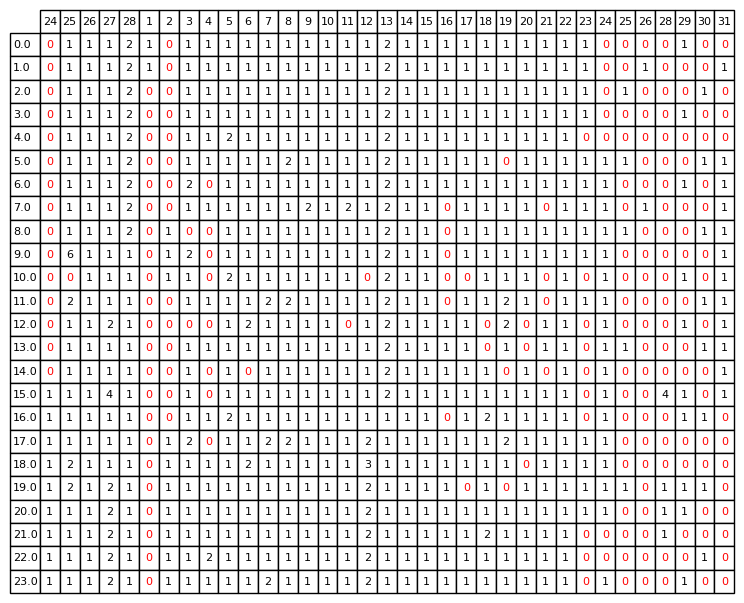

In [4]:
# Print the pivot table with grids and highlight count values of '0' in red font
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=pivot_table.values, colLabels=pivot_table.columns, rowLabels=pivot_table.index, cellLoc='center', loc='center')

# Apply styles to the table
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    if i > 0 and j > -1 and pivot_table.iat[i-1, j] == 0:
        cell.set_text_props(color='red')


table.auto_set_font_size(True)
table.set_fontsize(8)
table.scale(1.4, 1.4)



plt.show()

In [ ]:
'''# ensure conversion from net price to price including taxes..

from datetime import datetime

# Make sure the datetime column exists so we can determine the years
if 'date_time' not in merged_df.columns:
    merged_df['date_time'] = merged_df['x'].apply(lambda x: datetime.fromtimestamp(x * 100000 / 1000))

# Build a mapping of year to energy tax rate
years = merged_df['date_time'].dt.year.unique()
energy_tax_rates = {}
for year in sorted(years):
    if year == 2025:
        energy_tax_rates[year] = 0.1228
    else:
        rate_input = input(f"Enter energy tax rate for year {year}: ")
        try:
            energy_tax_rates[year] = float(rate_input)
        except Exception as e:
            print(f"Invalid input, defaulting energy tax rate for {year} to 0.0")
            energy_tax_rates[year] = 0.0

print("Energy tax rates by year:", energy_tax_rates)


ValueError: Invalid value NaN (not a number)

In [6]:
merged_df['Price'] = merged_df['y'] * 1.21 + energy_tax_rates[2025]


In [7]:
# Sort merged_df based on the proper datetime column to avoid plotting errors
merged_df = merged_df.sort_values(by=['date_timestamp', 'hour_timestamp', 'date_time'])

print("Sorted head values:")
print(merged_df.head(2))
print()
print("Sorted tail values:")
print(merged_df.tail(2))

Sorted head values:
                x      y                         timestamp  subarray  \
82824  17403516.0  0.010  2025-02-24T15:40:49.845469+00:00         0   
82873  17403516.0  0.152  2025-02-24T15:40:49.845469+00:00         1   

      date_timestamp  hour_timestamp  date_time    Price  
82824     2025-02-24              15 2025-02-24  0.13490  
82873     2025-02-24              15 2025-02-24  0.30672  

Sorted tail values:
               x      y                         timestamp  subarray  \
1876  17435772.0  0.160  2025-03-26T07:00:02.854228+00:00         4   
2077  17435772.0  0.134  2025-03-26T07:00:02.854228+00:00         5   

     date_timestamp  hour_timestamp           date_time    Price  
1876     2025-03-26               7 2025-04-02 09:00:00  0.31640  
2077     2025-03-26               7 2025-04-02 09:00:00  0.28494  


In [8]:
point_est_price_df = merged_df[merged_df['subarray'] == 1]

In [9]:

# Print the head and tail rows of point_est_price_df
print("head values")
print(point_est_price_df.head(2))
print()
print("tail values")
print(point_est_price_df.tail(2))

head values
                x      y                         timestamp  subarray  \
82873  17403516.0  0.152  2025-02-24T15:40:49.845469+00:00         1   
82874  17403552.0  0.145  2025-02-24T15:40:49.845469+00:00         1   

      date_timestamp  hour_timestamp           date_time    Price  
82873     2025-02-24              15 2025-02-24 00:00:00  0.30672  
82874     2025-02-24              15 2025-02-24 01:00:00  0.29825  

tail values
               x      y                         timestamp  subarray  \
1272  17435736.0  0.165  2025-03-26T07:00:02.854228+00:00         1   
1273  17435772.0  0.147  2025-03-26T07:00:02.854228+00:00         1   

     date_timestamp  hour_timestamp           date_time    Price  
1272     2025-03-26               7 2025-04-02 08:00:00  0.32245  
1273     2025-03-26               7 2025-04-02 09:00:00  0.30067  


// Price values match price shown on energie.theoxigent.nl, re-confirmed by checking price values most into the future. Based on CSV file 'oxygent_data/time_series_data_20250317 12:45.csv' //


In [10]:
import datetime

# Define the time range
start_time = datetime.datetime.now() - datetime.timedelta(hours=4)
end_time = datetime.datetime.now() + datetime.timedelta(days=7)

# Filter the DataFrame based on the time range
filtered_df = point_est_price_df[(point_est_price_df['date_time'] >= start_time) & (point_est_price_df['date_time'] <= end_time)]

# Further filter the DataFrame to only include hour_timestamp values equal to 1, 7, 13, or 19
filtered_df = filtered_df[(filtered_df['hour_timestamp'] == 1) | 
                          (filtered_df['hour_timestamp'] == 7) | 
                          (filtered_df['hour_timestamp'] == 13) | 
                          (filtered_df['hour_timestamp'] == 19)]

/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_32113/3755664397.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues", n_groups)


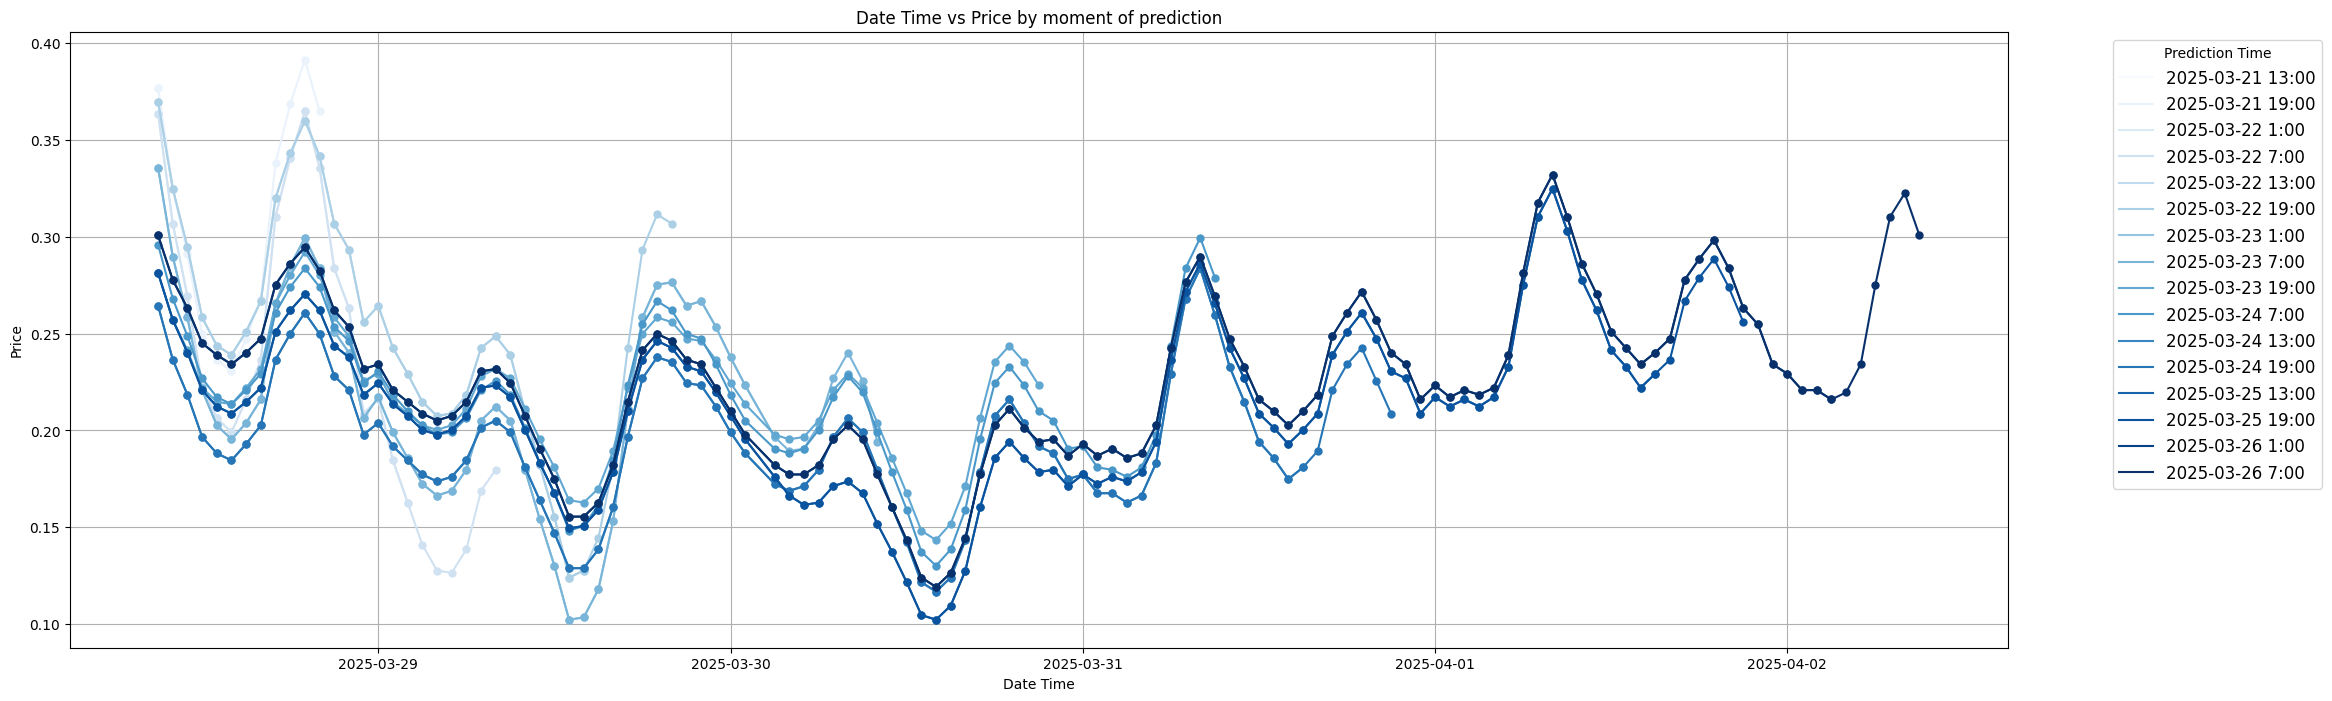

In [11]:
import matplotlib.cm as cm

# Group the filtered data by date_timestamp and hour_timestamp
unique_combinations = filtered_df.groupby(['date_timestamp', 'hour_timestamp'])
n_groups = len(unique_combinations)
cmap = cm.get_cmap("Blues", n_groups)

plt.figure(figsize=(25, 8))  # Adjust the figure size

line_handles = []  # to store line objects
labels = []
for i, ((date_timestamp, hour_timestamp), group) in enumerate(unique_combinations):
    color = plt.get_cmap("Blues", n_groups)(i)
    line, = plt.plot(group['date_time'], group['Price'], color=color,
                     marker='o', markersize=5, linestyle='-', 
                     label=f'{date_timestamp} {hour_timestamp}:00')
    line_handles.append(line)
    labels.append(f'{date_timestamp} {hour_timestamp}:00')

# Create custom legend handles showing only the line (color)
legend_handles = [
    plt.Line2D([], [], color=line.get_color(), linestyle=line.get_linestyle(), linewidth=line.get_linewidth())
    for line in line_handles
]

plt.xlabel('Date Time')
plt.ylabel('Price')
plt.title('Date Time vs Price by moment of prediction')
plt.ylim()  # Set no y-axis limits, alternatively: (0.0, 0.5) or similar
plt.legend(legend_handles, labels, title='Prediction Time', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)
plt.show()
